In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.models import Model
from google.colab import drive

print(" ✅TensorFlow ve gerekli kütüphaneler yüklendi.")


 ✅TensorFlow ve gerekli kütüphaneler yüklendi.


In [ ]:
drive.mount('/content/drive')
print("✅ Google Drive bağlantısı tamamlandı.")


Mounted at /content/drive
✅ Google Drive bağlantısı tamamlandı.


In [ ]:
base_dir = '/content/drive/MyDrive/veriseti/prcc'
rgb_dir = os.path.join(base_dir, 'rgb')
sketch_dir = os.path.join(base_dir, 'sketch')

train_rgb_dir = os.path.join(rgb_dir, 'train')
val_rgb_dir = os.path.join(rgb_dir, 'val')
train_sketch_dir = os.path.join(sketch_dir, 'train')
val_sketch_dir = os.path.join(sketch_dir, 'val')

print("✅ Veri seti dizinleri tanımlandı.")


✅ Veri seti dizinleri tanımlandı.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=45,  # Daha büyük dönüş açısı
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.5, 1.5],  # Parlaklık değişimi
    shear_range=0.3,  # Daha agresif kayma
    zoom_range=[0.8, 1.2],  # Daha büyük ölçeklendirme
    horizontal_flip=True
)


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),  # Öncekine göre daha fazla dönüşüm ekle
    tf.keras.layers.RandomZoom(0.1),  # Zoom oranını artır
    tf.keras.layers.RandomBrightness(0.4),  # Parlaklık değişimini artır
    tf.keras.layers.Lambda(lambda x: tf.image.adjust_contrast(x, 0.5))  # Kontrastı artırmak için alternatif yöntem
])

print("✅ Veri artırma katmanları başarıyla oluşturuldu.")


✅ Veri artırma katmanları başarıyla oluşturuldu.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Train RGB Generator
train_rgb_generator = train_datagen.flow_from_directory(
    train_rgb_dir,  # Removed the extra "/train"
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Validation RGB Generator
val_rgb_generator = val_datagen.flow_from_directory(
    val_rgb_dir,  # Removed the extra "/val" and used val_rgb_dir
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Validation için shuffle kapalı
)

# Train Sketch Generator
train_sketch_generator = train_datagen.flow_from_directory(
    train_sketch_dir,  # Removed the extra "/train"
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Validation Sketch Generator
val_sketch_generator = val_datagen.flow_from_directory(
    val_sketch_dir,  # Removed the extra "/val" and used val_sketch_dir
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Validation için shuffle kapalı
)


Found 17896 images belonging to 150 classes.
Found 5002 images belonging to 150 classes.
Found 17896 images belonging to 150 classes.
Found 5002 images belonging to 150 classes.


In [ ]:
print("RGB class indices:", train_rgb_generator.class_indices)
print("Sketch class indices:", train_sketch_generator.class_indices)


RGB class indices: {'092': 0, '095': 1, '098': 2, '102': 3, '104': 4, '107': 5, '108': 6, '109': 7, '110': 8, '111': 9, '113': 10, '114': 11, '115': 12, '119': 13, '121': 14, '122': 15, '123': 16, '124': 17, '125': 18, '126': 19, '127': 20, '128': 21, '143': 22, '147': 23, '149': 24, '150': 25, '151': 26, '154': 27, '155': 28, '157': 29, '158': 30, '160': 31, '163': 32, '164': 33, '165': 34, '168': 35, '169': 36, '170': 37, '171': 38, '172': 39, '174': 40, '175': 41, '177': 42, '178': 43, '179': 44, '180': 45, '181': 46, '184': 47, '185': 48, '189': 49, '190': 50, '193': 51, '194': 52, '197': 53, '198': 54, '199': 55, '200': 56, '201': 57, '203': 58, '204': 59, '205': 60, '206': 61, '207': 62, '208': 63, '209': 64, '211': 65, '213': 66, '215': 67, '217': 68, '218': 69, '220': 70, '221': 71, '222': 72, '224': 73, '225': 74, '226': 75, '227': 76, '228': 77, '229': 78, '231': 79, '232': 80, '234': 81, '235': 82, '237': 83, '240': 84, '243': 85, '244': 86, '245': 87, '246': 88, '247': 89, 

In [ ]:
# Shuffle (karıştırma) durumlarını kontrol et
print(f"Train RGB Shuffle: {train_rgb_generator.shuffle}")  # RGB veri seti shuffle edilmiş mi?
print(f"Train Sketch Shuffle: {train_sketch_generator.shuffle}")  # Sketch veri seti shuffle edilmiş mi?

# Bir batch al ve boyutlarını kontrol et
x1, y1 = next(train_rgb_generator)  # RGB veri setinden bir batch al
x2, y2 = next(train_sketch_generator)  # Sketch veri setinden bir batch al

#  Giriş verilerinin boyutlarını kontrol et
print(f"RGB Input Shape: {x1.shape}, Sketch Input Shape: {x2.shape}")  # RGB ve Sketch giriş veri boyutlarını yazdır

# RGB ve Sketch etiketlerini karşılaştır
print(f" RGB Labels: {np.argmax(y1, axis=1)}")  # RGB görüntüleri için etiketleri göster
print(f"Sketch Labels: {np.argmax(y2, axis=1)}")  # Sketch görüntüleri için etiketleri göster


Train RGB Shuffle: True
Train Sketch Shuffle: True
RGB Input Shape: (32, 224, 224, 3), Sketch Input Shape: (32, 224, 224, 3)
 RGB Labels: [144  66  65  19 116  15  62  37 118 121  10  39  46 118  28  68  50  28
 136  27  58  81 132   1  75  75  25  33 103 126   5  29]
Sketch Labels: [144  66  65  19 116  15  62  37 118 121  10  39  46 118  28  68  50  28
 136  27  58  81 132   1  75  75  25  33 103 126   5  29]


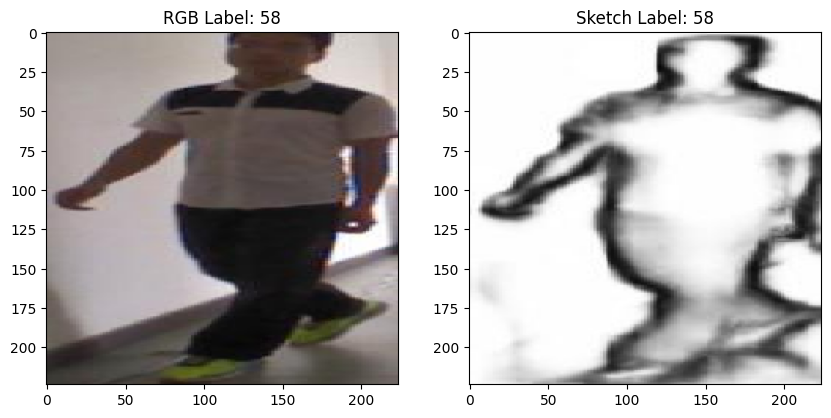

✅ Rastgele görüntü gösterildi.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Rastgele bir indeks seç
random_index = np.random.randint(len(x1))

# Görselleştirme için 1 satır ve 2 sütundan oluşan bir grafik alanı oluştur
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# RGB görüntüsünü çiz
axes[0].imshow(x1[random_index])
axes[0].set_title(f"RGB Label: {np.argmax(y1[random_index])}")

# Sketch görüntüsünü çiz
axes[1].imshow(x2[random_index])
axes[1].set_title(f"Sketch Label: {np.argmax(y2[random_index])}")

# Grafikleri göster
plt.show()

print("✅ Rastgele görüntü gösterildi.")


In [ ]:
# 10 farklı batch için kontrol yap
for i in range(5):
    x1, y1 = next(train_rgb_generator)  # RGB veri kümesinden bir batch al
    x2, y2 = next(train_sketch_generator)  # Sketch veri kümesinden bir batch al

    # RGB ve Sketch veri kümelerinin batch içerisindeki etiketlerini yazdır
    print(f"Batch {i+1} - RGB Labels: {np.argmax(y1, axis=1)}")
    print(f"Batch {i+1} - Sketch Labels: {np.argmax(y2, axis=1)}")

    # Batch sınırlarını ayırmak için çizgi ekle
    print("-" * 50)


Batch 1 - RGB Labels: [124  88  69  61 135  52  43  43  94 106  90  18 116  99 128  46  97  76
  61   0  31   5 108  92  42   1  94 119  17  45  27  29]
Batch 1 - Sketch Labels: [124  88  69  61 135  52  43  43  94 106  90  18 116  99 128  46  97  76
  61   0  31   5 108  92  42   1  94 119  17  45  27  29]
--------------------------------------------------
Batch 2 - RGB Labels: [ 39 108 118  99  57  51  71   9   8  42 125  86  74  57  29 120 137 130
  73  78  36   2 104 123 117  27  65 133  11  85   7  36]
Batch 2 - Sketch Labels: [ 39 108 118  99  57  51  71   9   8  42 125  86  74  57  29 120 137 130
  73  78  36   2 104 123 117  27  65 133  11  85   7  36]
--------------------------------------------------
Batch 3 - RGB Labels: [  2  92  44   0  56 125   5 146   3 115 143 148   0  26 100  74 105  77
  85 140  65  61  42 146  55  20  96 117  76  35 129  43]
Batch 3 - Sketch Labels: [  2  92  44   0  56 125   5 146   3 115 143 148   0  26 100  74 105  77
  85 140  65  61  42 146  55 

In [ ]:
print(f"Gerçek Eğitim Batch Sayısı: {len(train_rgb_generator)}")
print(f"Gerçek Doğrulama Batch Sayısı: {len(val_rgb_generator)}")


Gerçek Eğitim Batch Sayısı: 560
Gerçek Doğrulama Batch Sayısı: 157


In [ ]:
print(f"Toplam Eğitim Görüntü Sayısı: {train_rgb_generator.samples}")
print(f"Toplam Doğrulama Görüntü Sayısı: {val_rgb_generator.samples}")


Toplam Eğitim Görüntü Sayısı: 17896
Toplam Doğrulama Görüntü Sayısı: 5002


In [ ]:
import numpy as np  # Sayısal işlemler için NumPy kütüphanesi import ediliyor

# İlk batch'ten RGB ve Sketch etiketlerini alalım
x1, y1 = next(train_rgb_generator)  # RGB veri kümesinden bir batch al
x2, y2 = next(train_sketch_generator)  # Sketch veri kümesinden bir batch al

# İlk 10 verinin etiketlerini yazdırarak kontrol edelim
print("RGB Labels:", np.argmax(y1[:10], axis=1))  # İlk 10 RGB görüntüsünün etiketlerini yazdır
print("Sketch Labels:", np.argmax(y2[:10], axis=1))  # İlk 10 Sketch görüntüsünün etiketlerini yazdır

# Eğer iki liste tamamen aynıysa, shuffle işlemi başarılıdır!
if np.array_equal(np.argmax(y1[:10], axis=1), np.argmax(y2[:10], axis=1)):
    print("✅ RGB ve Sketch Shuffle tamamen senkronize!")  # Eşleşme doğruysa başarılı mesajı ver
else:
    print("RGB ve Sketch Shuffle senkronize DEĞİL! Kontrol et.")  # Eşleşme hatalıysa uyarı mesajı ver


RGB Labels: [ 88  25 144  78  36 148  20  88  58  19]
Sketch Labels: [ 88  25 144  78  36 148  20  88  58  19]
✅ RGB ve Sketch Shuffle tamamen senkronize!


In [ ]:
# Model girişlerini tanımla
input_rgb = Input(shape=(224, 224, 3), name="input_rgb")
input_sketch = Input(shape=(224, 224, 3), name="input_sketch")



In [ ]:
import tensorflow as tf

def create_multimodal_dataset(rgb_generator, sketch_generator):
    """Creates a multimodal dataset by zipping RGB and Sketch generators."""
    # Create datasets from generators
    rgb_dataset = tf.data.Dataset.from_generator(
        lambda: rgb_generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # RGB images
            tf.TensorSpec(shape=(None, rgb_generator.num_classes), dtype=tf.float32)
        )
    )

    sketch_dataset = tf.data.Dataset.from_generator(
        lambda: sketch_generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Sketch images
            tf.TensorSpec(shape=(None, sketch_generator.num_classes), dtype=tf.float32)
        )
    )

    # Zip the datasets, ensuring labels match
    def filter_fn(rgb_data, sketch_data):
        rgb_img, rgb_label = rgb_data
        sketch_img, sketch_label = sketch_data
        return tf.reduce_all(tf.equal(rgb_label, sketch_label))

    multimodal_dataset = tf.data.Dataset.zip((rgb_dataset, sketch_dataset))
    multimodal_dataset = multimodal_dataset.filter(filter_fn)

    # Restructure to (rgb_image, sketch_image), label
    multimodal_dataset = multimodal_dataset.map(
        lambda rgb_data, sketch_data: ((rgb_data[0], sketch_data[0]), rgb_data[1])  # Use rgb_data[1] as labels
    )

    # Batch the dataset after restructuring
    multimodal_dataset = multimodal_dataset.batch(32)

    return multimodal_dataset

# Create the multimodal dataset
multimodal_train_dataset = create_multimodal_dataset(train_rgb_generator, train_sketch_generator)
multimodal_val_dataset = create_multimodal_dataset(val_rgb_generator, val_sketch_generator) # Added validation dataset creation

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Concatenate, BatchNormalization, Dense
from tensorflow.keras.models import Model

# Model girişleri (Doğrudan Model'e eklenecek)
input_rgb = Input(shape=(224, 224, 3), name="input_rgb_new")
input_sketch = Input(shape=(224, 224, 3), name="input_sketch_new")

# VGG16 modellerini tanımla (input_tensor KULLANMA)
vgg_rgb = VGG16(weights='imagenet', include_top=False, name="vgg_rgb_model")
vgg_sketch = VGG16(weights='imagenet', include_top=False, name="vgg_sketch_model")

# Tüm katmanları dondur
for layer in vgg_rgb.layers:
    layer.trainable = False
for layer in vgg_sketch.layers:
    layer.trainable = False

# Sadece son katmanı aç
vgg_rgb.layers[-1].trainable = True
vgg_sketch.layers[-1].trainable = True

# Özellik çıkarımı
rgb_features = vgg_rgb(input_rgb)
sketch_features = vgg_sketch(input_sketch)

# Batch Normalization uygula
rgb_features = BatchNormalization()(rgb_features)
sketch_features = BatchNormalization()(sketch_features)

# Global Average Pooling uygula
rgb_features = GlobalAveragePooling2D()(rgb_features)
sketch_features = GlobalAveragePooling2D()(sketch_features)

# Tekrar Batch Normalization uygula
rgb_features = BatchNormalization()(rgb_features)
sketch_features = BatchNormalization()(sketch_features)

# RGB ve Sketch özelliklerini birleştir
merged_features = Concatenate()([rgb_features, sketch_features])

# Tam bağlı katman (512 nöron)
dense1 = Dense(512, activation="relu")(merged_features)
dense1 = BatchNormalization()(dense1)

# Çıkış katmanı
output_layer = Dense(10, activation="softmax")(dense1)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
from tensorflow.keras.models import Model

# Eğitim veri kümesinden sınıf sayısını al
num_classes = len(train_rgb_generator.class_indices)

# Dropout oranını belirle (Farklı katmanlar için)
dropout_rate = 0.5  # **Daha etkili regularization için artırıldı**

# İlk tam bağlı katman (512 nöron)
dense1 = Dense(512, activation="relu")(merged_features)
dense1 = Dropout(dropout_rate)(dense1)  # **Dropout önce**
dense1 = BatchNormalization()(dense1)  # **Sonra Batch Normalization**

# İkinci tam bağlı katman (256 nöron)
dense2 = Dense(256, activation="relu")(dense1)
dense2 = Dropout(dropout_rate)(dense2)  # **Dropout önce**
dense2 = BatchNormalization()(dense2)  # **Sonra Batch Normalization**

# Çıkış katmanı (Softmax ile sınıflandırma)
output_layer = Dense(num_classes, activation="softmax")(dense2)

print("✅ Tam bağlı katmanlar eklendi ve **Dropout oranı artırıldı**.")


✅ Tam bağlı katmanlar eklendi ve **Dropout oranı artırıldı**.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

# Yeni learning rate belirle
initial_learning_rate = 0.001  # Daha stabil başlangıç
batch_size = 32  # Default batch size kullan
epochs = 40  # Eğitim için belirlenen toplam epoch sayısı

# Learning rate scheduler fonksiyonu
def lr_schedule(epoch):
    if epoch < 10:
        return initial_learning_rate  # İlk 10 epoch sabit
    elif 10 <= epoch < 20:
        return initial_learning_rate * 0.1  # 10-20 epoch arası 0.1 ile çarp
    else:
        return initial_learning_rate * 0.01  # 20. epoch sonrası 0.01 ile çarp

# Optimizasyon algoritmasını belirle
optimizer = SGD(learning_rate=initial_learning_rate, momentum=0.9)

# Modeli oluştur
multimodal_model = Model(inputs=[input_rgb, input_sketch], outputs=output_layer)

# Modeli derle
multimodal_model.compile(
    optimizer=optimizer,  # Yeni optimize edilmiş learning rate kullan
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Öğrenme oranını güncelleme callback'i ekle
lr_callback = LearningRateScheduler(lr_schedule)

print("✅ Öğrenme oranı güncellendi. Yeni öğrenme oranı:", initial_learning_rate)


# Modelin katmanlarını özetle göster
multimodal_model.summary()



✅ Öğrenme oranı güncellendi. Yeni öğrenme oranı: 0.001


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_rgb_new             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_sketch_new          │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg_rgb_model             │ (None, 7, 7, 512)      │     14,714,688 │ input_rgb_new[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg_sketch_model          │ (None, 7, 7, 512)      │     14,714,688 │ input_sketch_new[0][0] │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 7, 7, 512)      │          2,048 │ vgg_rgb_model[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 7, 7, 512)      │          2,048 │ vgg_sketch_model[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ batch_normalization[0… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ batch_normalization_1… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 512)            │          2,048 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 512)            │          2,048 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1024)           │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │        524,800 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 512)            │          2,048 │ dropout[0][0]          │
│ (BatchNormalization) 

 Total params: 30,135,318 (114.96 MB)

 Trainable params: 700,310 (2.67 MB)

 Non-trainable params: 29,435,008 (112.29 MB)

In [ ]:
import tensorflow as tf  #  TensorFlow veri işlemleri için import ediliyor

#  Dataset Generator - ZIP'leme işlemi
def generate_data_generator(generator1, generator2):
    while True:
        x1, y1 = next(generator1)  #  RGB veri kümesinden bir batch al
        x2, y2 = next(generator2)  #  Sketch veri kümesinden bir batch al
        min_samples = min(x1.shape[0], x2.shape[0])  # Her iki batch'teki en küçük örnek sayısını belirle
        yield (x1[:min_samples], x2[:min_samples]), tf.argmax(y1[:min_samples], axis=1)  #  Veri çiftini ve etiketleri döndür

# Eğitim veri setini TensorFlow Dataset formatına çevir
train_dataset = tf.data.Dataset.from_generator(
    lambda: generate_data_generator(train_rgb_generator, train_sketch_generator),
    output_signature=(
        (tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  #  RGB giriş verisi
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)),  # Sketch giriş verisi
        tf.TensorSpec(shape=(None,), dtype=tf.int64)  #  Çıkış etiketleri
    )
)

#  Doğrulama veri seti için aynı işlemi tekrarla
val_dataset = tf.data.Dataset.from_generator(
    lambda: generate_data_generator(val_rgb_generator, val_sketch_generator),
    output_signature=(
        (tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  #  RGB giriş verisi
         tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)),  # Sketch giriş verisi
        tf.TensorSpec(shape=(None,), dtype=tf.int64)  # Çıkış etiketleri
    )
)

#  İşlemin tamamlandığını ekrana yazdır
print("✅ Eğitim ve doğrulama veri setleri başarıyla ZIP'lendi.")


✅ Eğitim ve doğrulama veri setleri başarıyla ZIP'lendi.


In [ ]:
import matplotlib.pyplot as plt  #  Görselleştirme için Matplotlib import ediliyor
import numpy as np  #  Sayısal işlemler için NumPy import ediliyor

#  Eğitim döngüsü: Her epoch öncesinde shuffle ve batch doğrulama yap
for epoch in range(1, 11):  # 10 epoch boyunca döngü çalışacak
    print(f"\n Epoch {epoch} başlıyor... Shuffle ve batch doğrulaması yapılıyor.")

    # Shuffle ve batch doğrulaması
    x1, y1 = next(train_rgb_generator)  # RGB veri kümesinden bir batch al
    x2, y2 = next(train_sketch_generator)  # Sketch veri kümesinden bir batch al

    #  RGB ve Sketch veri boyutlarını yazdır
    print(f" RGB Input Shape: {x1.shape}, Sketch Input Shape: {x2.shape}")

    # RGB ve Sketch etiketlerini yazdır
    print(f"RGB Labels: {np.argmax(y1, axis=1)}")
    print(f"Sketch Labels: {np.argmax(y2, axis=1)}")

    # RGB ve Sketch görsellerini ekrana çiz
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Yan yana 2 görsel gösterilecek

    axes[0].imshow(x1[0])  # İlk RGB görüntüsünü göster
    axes[0].set_title(f"RGB Label: {np.argmax(y1[0])}")  #  RGB etiketini başlık olarak ekle

    axes[1].imshow(x2[0], cmap='gray')  #  İlk Sketch görüntüsünü göster (gri tonlamalı)
    axes[1].set_title(f"Sketch Label: {np.argmax(y2[0])}")  #  Sketch etiketini başlık olarak ekle

    #  Grafikleri ekrana getir
    plt.show()

    print(f"✅ Epoch {epoch} öncesi görselleştirme tamamlandı.")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
multimodal_train_dataset = multimodal_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
multimodal_val_dataset = multimodal_val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Calculate train_steps and val_steps
train_steps = len(train_rgb_generator)  # Total number of batches in the training set
val_steps = len(val_rgb_generator)   # Total number of batches in the validation set


history = multimodal_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    batch_size=32,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,

)
print("\n✅ Model eğitimi tamamlandı! 🎉")



Epoch 1/40
560/560 ━━━━━━━━━━━━━━━━━━━━ 33748s 60s/step - accuracy: 0.0136 - loss: 5.4254 - val_accuracy: 0.1749 - val_loss: 4.3415
Epoch 2/40
560/560 ━━━━━━━━━━━━━━━━━━━━ 250s 446ms/step - accuracy: 0.0592 - loss: 4.7127 - val_accuracy: 0.3555 - val_loss: 3.6191
Epoch 3/40
560/560 ━━━━━━━━━━━━━━━━━━━━ 247s 441ms/step - accuracy: 0.1215 - loss: 4.2331 - val_accuracy: 0.4750 - val_loss: 3.1243
Epoch 4/40
560/560 ━━━━━━━━━━━━━━━━━━━━ 248s 444ms/step - accuracy: 0.1924 - loss: 3.8196 - val_accuracy: 0.5488 - val_loss: 2.7065
Epoch 5/40
560/560 ━━━━━━━━━━━━━━━━━━━━ 248s 443ms/step - accuracy: 0.2450 - loss: 3.4963 - val_accuracy: 0.6212 - val_loss: 2.3604
Epoch 6/40
560/560 ━━━━━━━━━━━━━━━━━━━━ 248s 442ms/step - accuracy: 0.3076 - loss: 3.1847 - val_accuracy: 0.6885 - val_loss: 2.0554
Epoch 7/40
560/560 ━━━━━━━━━━━━━━━━━━━━ 247s 442ms/step - accuracy: 0.3549 - loss: 2.9324 - val_accuracy: 0.7329 - val_loss: 1.7930
Epoch 8/40
560/560 ━━━━━━━━━━━━━━━━━━━━ 247s 441ms/step - accuracy: 0.3932 -

In [ ]:
# Modeli yeni Keras formatında kaydet (ÖNERİLEN YÖNTEM)
model_save_path = "/content/drive/MyDrive/veriseti/vgg16_multimodal_model.keras" # .keras uzantısı eklendi
multimodal_model.save(model_save_path)

print(f"✅ Model başarıyla {model_save_path} konumuna kaydedildi!")

✅ Model başarıyla /content/drive/MyDrive/veriseti/vgg16_multimodal_model.keras konumuna kaydedildi!


# **TEST ASAMASI**

In [ ]:
# Modeli yeni Keras formatında kaydet (ÖNERİLEN YÖNTEM)
model_save_path = "/content/drive/MyDrive/veriseti/vgg16_multimodal_model.keras" # .keras uzantısı eklendi
multimodal_model.save(model_save_path)

print(f"✅ Model başarıyla {model_save_path} konumuna kaydedildi!")

✅ Model başarıyla /content/drive/MyDrive/veriseti/vgg16_multimodal_model.keras konumuna kaydedildi!


Multimodal modele uygun şekilde bu fonksiyonu güncelleyelim. RGB ve Sketch verilerinin birlikte işlenmesi gerektiği için her bir görüntü setinin hem RGB hem de Sketch versiyonlarını alarak aynı ID’ler ile eşleştirmeliyiz.

In [ ]:
def prepare_test_sets(data_rgb, data_sketch):
    print(" Galeri Verileri (RGB + Sketch):")
    gallery_rgb = data_rgb[data_rgb['camera'] == 'A']
    gallery_sketch = data_sketch[data_sketch['camera'] == 'A']

    print(" Probe B Verileri (RGB + Sketch):")
    probe_B_rgb = data_rgb[data_rgb['camera'] == 'B']
    probe_B_sketch = data_sketch[data_sketch['camera'] == 'B']

    print(" Probe C Verileri (RGB + Sketch):")
    probe_C_rgb = data_rgb[data_rgb['camera'] == 'C']
    probe_C_sketch = data_sketch[data_sketch['camera'] == 'C']

    return gallery_rgb, gallery_sketch, probe_B_rgb, probe_B_sketch, probe_C_rgb, probe_C_sketch


Aşağıdaki kodu multimodal test sürecine uygun hale getirmek için hem RGB hem de Sketch görüntülerini birlikte işleyecek şekilde güncelleyelim.
RGB ve Sketch test verilerinin eşleşmesini sağlar.
Aynı ID’ye sahip görüntülerin RGB ve Sketch versiyonlarını yükler.
Bu iki görüntüyü kanal bazında birleştirerek tek bir multimodal giriş oluşturur.
Eğitimde kullanılan multimodal modelden özellik çıkartır. mevcut süreci genişleterek multimodal bir test süreci oluşturur.

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def preprocess_image(image_path, target_size=(224, 224)):
    """
    Görseli yükler, normalize eder ve uygun giriş formatına getirir.
    """
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize et
    img_array = img_array.reshape((1,) + img_array.shape)  # Batch boyutu ekle
    return img_array

def extract_multimodal_features(model, rgb_root_dir, sketch_root_dir, camera_label):
    features, ids, cameras = [], [], []

    # RGB klasöründeki tüm ID'leri al
    for root, _, files in os.walk(rgb_root_dir):
        for file_name in files:
            if file_name.endswith('.jpg') or file_name.endswith('.png'):
                rgb_path = os.path.join(root, file_name)

                # Sketch versiyonunu bul
                sketch_path = rgb_path.replace(rgb_root_dir, sketch_root_dir)  # Sketch dosya yolu oluştur
                if not os.path.exists(sketch_path):
                    print(f" Sketch dosyası bulunamadı: {rgb_path}, atlanıyor...")
                    continue

                print(f" RGB: {rgb_path} 🖼 Sketch: {sketch_path}")

                # Görselleri yükleyip modele uygun hale getir
                rgb_img = preprocess_image(rgb_path)
                sketch_img = preprocess_image(sketch_path)

                # İki görüntüyü ayrı ayrı modele ver
                feature = model.predict([rgb_img, sketch_img])  # Modele iki giriş ver

                features.append(feature.squeeze())  # 1D vektöre dönüştür

                # ID ve kamera bilgisini kaydet
                id_label = os.path.basename(os.path.dirname(rgb_path))
                ids.append(id_label)
                cameras.append(camera_label)

    print(f"✅ {len(features)} özellik çıkarıldı!")
    return np.array(features), ids, cameras

 RGB ve Sketch verilerinden çıkarılan özellikler zaten birleştirilmişti.
Bu adımda, multimodal test veri setini galeri ve probe setlerine ayırıyoruz. Galeride kayıtlı olan verilerle, probe setindeki verileri eşleştirerek test gerçekleştireceğiz.
ID ve kamera bilgileriyle birlikte test verilerini organize ettik.

In [ ]:
# Klasör yollarını belirle
rgb_a_dir = '/content/drive/MyDrive/veriseti/prcc/rgb/test/A'
rgb_b_dir = '/content/drive/MyDrive/veriseti/prcc/rgb/test/B'
rgb_c_dir = '/content/drive/MyDrive/veriseti/prcc/rgb/test/C'

sketch_a_dir = '/content/drive/MyDrive/veriseti/prcc/sketch/test/A'
sketch_b_dir = '/content/drive/MyDrive/veriseti/prcc/sketch/test/B'
sketch_c_dir = '/content/drive/MyDrive/veriseti/prcc/sketch/test/C'

# Özellikleri çıkar
features_A, ids_A, cameras_A = extract_multimodal_features(multimodal_model, rgb_a_dir, sketch_a_dir, 'A')
features_B, ids_B, cameras_B = extract_multimodal_features(multimodal_model, rgb_b_dir, sketch_b_dir, 'B')
features_C, ids_C, cameras_C = extract_multimodal_features(multimodal_model, rgb_c_dir, sketch_c_dir, 'C')

# Verileri birleştir
all_features = np.concatenate([features_A, features_B, features_C], axis=0)
all_ids = ids_A + ids_B + ids_C
all_cameras = cameras_A + cameras_B + cameras_C

# Test setini oluştur
import pandas as pd
test_data = pd.DataFrame({
    'features': list(all_features),
    'id': all_ids,
    'camera': all_cameras
})

print("✅ Multimodal test veri seti hazır!")
print(test_data.head())  # İlk birkaç örneği göster

# Gallery ve probe setlerini oluştur
gallery = test_data[test_data['camera'] == 'A'] # Gallery seti kamera A'dan gelen veriler
probe_B = test_data[test_data['camera'] == 'B'] # Probe seti kamera B'den gelen veriler
probe_C = test_data[test_data['camera'] == 'C'] # Probe seti kamera C'den gelen veriler

Streaming output truncated to the last 5000 lines.
 RGB: /content/drive/MyDrive/veriseti/prcc/rgb/test/C/063/cropped_rgb019.jpg 🖼 Sketch: /content/drive/MyDrive/veriseti/prcc/sketch/test/C/063/cropped_rgb019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
 RGB: /content/drive/MyDrive/veriseti/prcc/rgb/test/C/063/cropped_rgb043.jpg 🖼 Sketch: /content/drive/MyDrive/veriseti/prcc/sketch/test/C/063/cropped_rgb043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
 RGB: /content/drive/MyDrive/veriseti/prcc/rgb/test/C/063/cropped_rgb028.jpg 🖼 Sketch: /content/drive/MyDrive/veriseti/prcc/sketch/test/C/063/cropped_rgb028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
 RGB: /content/drive/MyDrive/veriseti/prcc/rgb/test/C/063/cropped_rgb073.jpg 🖼 Sketch: /content/drive/MyDrive/veriseti/prcc/sketch/test/C/063/cropped_rgb073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
 RGB: /content/drive/MyDrive/veriseti/prcc/rgb/test/C/063/cropped_rgb304.jpg 🖼 Sketch: /content/drive/MyDrive/veriseti/prcc/sketch/test/C/063/cropped_rgb

In [ ]:
import numpy as np

def rank_k_matching_multimodal(gallery, probe, k):
    """
    Multimodal model ile Rank-K doğruluk hesaplama fonksiyonu.
    - Gallery: Referans feature vektörleri (RGB + Sketch)
    - Probe: Test edilmek istenen feature vektörleri (RGB + Sketch)
    - k: Kaç en iyi eşleşmenin dikkate alınacağını belirler (Rank-1, Rank-5, Rank-10, Rank-20)
    """
    correct_matches = 0  # Doğru eşleşmeleri saymak için

    for i in range(len(probe)):
        probe_feature = probe.iloc[i]['features']  # Probe'daki özellik vektörü (RGB + Sketch)
        probe_id = probe.iloc[i]['id']  # Probe'daki gerçek ID (kişinin kimliği)

        distances = []
        for j in range(len(gallery)):
            gallery_feature = gallery.iloc[j]['features']  # Gallery'deki multimodal feature
            dist = np.linalg.norm(probe_feature - gallery_feature)  # Öklid mesafesi hesapla
            distances.append((dist, gallery.iloc[j]['id']))  # (Mesafe, ID) çiftleri olarak kaydet

        # Mesafeye göre sıralayıp ilk K tahmini seç
        top_k_ids = [item[1] for item in sorted(distances, key=lambda x: x[0])[:k]]

        # Eğer probe ID, top-k tahminleri arasında varsa eşleşme doğru
        if probe_id in top_k_ids:
            correct_matches += 1

    return correct_matches / len(probe)  # Doğruluk oranını hesapla


In [ ]:
# Rank-1 doğruluk hesaplama
rank_1_accuracy_B = rank_k_matching_multimodal(gallery, probe_B, k=1)
rank_1_accuracy_C = rank_k_matching_multimodal(gallery, probe_C, k=1)

# Rank-5 doğruluk hesaplama
rank_5_accuracy_B = rank_k_matching_multimodal(gallery, probe_B, k=5)
rank_5_accuracy_C = rank_k_matching_multimodal(gallery, probe_C, k=5)

# Rank-10 doğruluk hesaplama
rank_10_accuracy_B = rank_k_matching_multimodal(gallery, probe_B, k=10)
rank_10_accuracy_C = rank_k_matching_multimodal(gallery, probe_C, k=10)

# Rank-20 doğruluk hesaplama
rank_20_accuracy_B = rank_k_matching_multimodal(gallery, probe_B, k=20)
rank_20_accuracy_C = rank_k_matching_multimodal(gallery, probe_C, k=20)


In [ ]:
print("\n###  Rank-K Doğruluk Oranları  ###")

# Rank-1 sonuçları
print(f" Rank-1 Accuracy (Gallery vs Probe B): {rank_1_accuracy_B:.4f}")
print(f" Rank-1 Accuracy (Gallery vs Probe C): {rank_1_accuracy_C:.4f}")

# Rank-5 sonuçları
print(f" Rank-5 Accuracy (Gallery vs Probe B): {rank_5_accuracy_B:.4f}")
print(f" Rank-5 Accuracy (Gallery vs Probe C): {rank_5_accuracy_C:.4f}")

# Rank-10 sonuçları
print(f" Rank-10 Accuracy (Gallery vs Probe B): {rank_10_accuracy_B:.4f}")
print(f" Rank-10 Accuracy (Gallery vs Probe C): {rank_10_accuracy_C:.4f}")

# Rank-20 sonuçları
print(f" Rank-20 Accuracy (Gallery vs Probe B): {rank_20_accuracy_B:.4f}")
print(f" Rank-20 Accuracy (Gallery vs Probe C): {rank_20_accuracy_C:.4f}")

print("\n Rank-K doğruluk hesaplamaları tamamlandı!")



### 🔥 Rank-K Doğruluk Oranları 🔥 ###
 Rank-1 Accuracy (Gallery vs Probe B): 0.1810
 Rank-1 Accuracy (Gallery vs Probe C): 0.0898
 Rank-5 Accuracy (Gallery vs Probe B): 0.3971
 Rank-5 Accuracy (Gallery vs Probe C): 0.1959
 Rank-10 Accuracy (Gallery vs Probe B): 0.5257
 Rank-10 Accuracy (Gallery vs Probe C): 0.2752
 Rank-20 Accuracy (Gallery vs Probe B): 0.6519
 Rank-20 Accuracy (Gallery vs Probe C): 0.3706

 Rank-K doğruluk hesaplamaları tamamlandı!
